# Running forward dynamics in a connectome-constrained model

The goal of this tutorial is to walk you through the following steps:

- Initializing a sparse neural network model based on a connectome. In this example, we will use the optic lobe of *Drosophila* as done in [Lappalainen et al. (2024)](https://www.nature.com/articles/s41586-024-07939-3).
- Specifying input and output projections.
- Driving activity in the network with visual inputs.

For demonstration purposes, we'll use flattened MNIST images as inputs into the connectome. This is however simplistic and we do allow for arbitrarily complex input mappings. To learn how to do that please refer to the API.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

from bioplnn.models import ConnectomeODERNN

Check the device to make sure you are on a GPU. If you aren't its not a big deal. Its just going to take much longer!

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("high")
print("Using device: {}".format(device))

Using device: cuda


Download the connectome and read it in as a torch tensor. We have pre-processed this as a sparse tensor for the purposes of this example.

In [3]:
save_dir = "connectivity/turaga"
os.makedirs(save_dir, exist_ok=True)
!gdown "https://drive.google.com/uc?id=18448HYpYrm60boziHG73bxN4CK5jG-1g" -O "{save_dir}/turaga-dros-visual-connectome.pt"
connectome = torch.load(
    os.path.join(save_dir, "turaga-dros-visual-connectome.pt"),
    weights_only=True,
)

Downloading...
From (original): https://drive.google.com/uc?id=18448HYpYrm60boziHG73bxN4CK5jG-1g
From (redirected): https://drive.google.com/uc?id=18448HYpYrm60boziHG73bxN4CK5jG-1g&confirm=t&uuid=8072a385-17ef-49c8-aa46-8a6d1ee6f5cf
To: /net/vast-storage/scratch/vast/mcdermott/lakshmin/torch-bioplnn-dev/examples/connectivity/turaga/turaga-dros-visual-connectome.pt
100%|█████████████████████████████████████████| 111M/111M [00:01<00:00, 109MB/s]


Connectome dimensions: 47521x47521
Number of synapses: 4623254


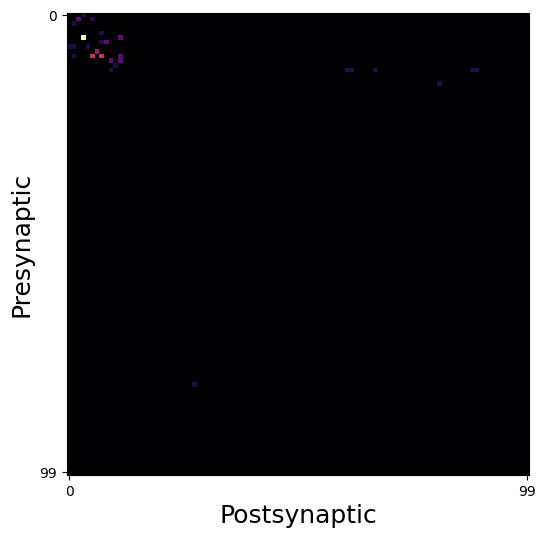

In [4]:
print(
    "Connectome dimensions: {}x{}".format(
        connectome.shape[0], connectome.shape[1]
    )
)
print("Number of synapses: {}".format(connectome._nnz()))

spatial_extent = 100
vmin, vmax = connectome.values().min(), connectome.values().max()
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(
    torch.abs(connectome.to_dense()[:spatial_extent, :spatial_extent]),
    cmap="inferno",
)
ax.set_xlabel("Postsynaptic", fontsize=18)
ax.set_ylabel("Presynaptic", fontsize=18)
ax.set_xticks([0, spatial_extent - 1])
ax.set_yticks([0, spatial_extent - 1])
plt.show()

## Creating input and output projection matrices
To drive the network with external inputs, you'd want to specify the subset of neurons in the model that receive input or project to downstream areas. We have an utility to create these sparse projection matrices. For the purposes of this example, we shall pick a random subset of input/output neurons. 
In a world where each neuron receives external input, you can also initialize this projection as an arbitrary *dense* matrix.

In [5]:
from bioplnn.utils.torch import create_sparse_projection

# since we are feeding in MNIST images
input_size = 28 * 28
num_neurons = connectome.shape[0]

input_projection_matrix = create_sparse_projection(
    size=input_size,
    num_neurons=num_neurons,
    indices=torch.randint(high=num_neurons, size=(input_size,)),
    mode="ih",
)

# for now, lets just read outputs from all neurons
output_projection_matrix = None

## Setting up the connectome-constrained model

In [6]:
connectome_rnn_kwargs = {
    "input_size": input_size,
    "num_neurons": num_neurons,
    "connectome": connectome,
    "input_projection": input_projection_matrix,
    "output_projection": output_projection_matrix,
    "neuron_nonlinearity": "Sigmoid",
    "batch_first": False,
    "compile_solver_kwargs": {
        "mode": "max-autotune",
        "dynamic": False,
        "fullgraph": True,
    },
}
model = ConnectomeODERNN(**connectome_rnn_kwargs).to(device)
print(model)

ConnectomeODERNN(
  (nonlinearity): Sigmoid()
  (hh): SparseLinear()
  (ih): SparseLinear()
  (ho): Identity()
  (solver): OptimizedModule(
    (_orig_mod): AutoDiffAdjoint(step_method=Dopri5(
      (term): ODETerm()
    ), step_size_controller=IntegralController(
      (term): ODETerm()
    ), max_steps=None, backprop_through_step_size_control=True)
  )
  (neuron_nonlinearity): Sigmoid()
)


In [7]:
# get some data for us to pipe into the model
transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])
train_data = MNIST(root="data", train=True, transform=transform, download=True)
train_loader = DataLoader(
    train_data, batch_size=8, num_workers=0, shuffle=True
)

In [8]:
# getting one batch of the input
x, label = next(iter(train_loader))
print(f"x shape: {x.shape}, label_shape: {label.shape}")
x = x.flatten(1)
x = x.to(device)
print(f"x flattened shape: {x.shape}")

x shape: torch.Size([8, 1, 28, 28]), label_shape: torch.Size([8])
x flattened shape: torch.Size([8, 784])


In [9]:
model.eval()
_, neural_activities, timesteps = model(
    x, start_time=0, end_time=1.0, num_evals=20
)
print(f"Neural activity shape: {neural_activities.shape}")

Neural activity shape: torch.Size([20, 8, 47521])


Text(0, 0.5, 'Activity')

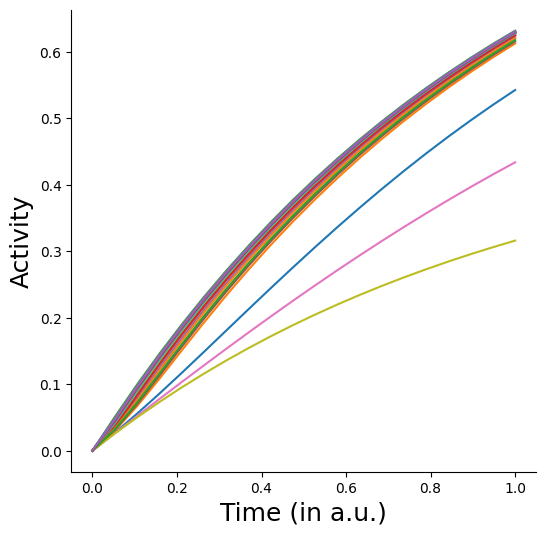

In [10]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(
    timesteps[:, 0].detach().cpu().numpy(),
    neural_activities[:, 0, torch.randint(0, 47521, (25,))]
    .detach()
    .cpu()
    .numpy(),
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Time (in a.u.)", fontsize=18)
ax.set_ylabel("Activity", fontsize=18)